In [1]:
#image analysis
import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
from scipy import optimize
import glob
from alienlab.regression_func import *
import copy
from VoltageIntensityClass import VoltageIntensity
from tqdm import tqdm

from skimage.transform import resize


#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename, askdirectory

from VoltageIntensityClass import VoltageIntensity

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib ipympl
from alienlab.widget import click_to_graph



def residuals(parameters,x_data,y_observed,func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters,x_data) - y_observed

def platt(parameters, xdata):
    M = parameters[0]
    alpha = parameters[1]
    return M*(1- np.exp(-alpha*xdata/M))

def modele_direct(parameters, x_data):
    a = parameters[0]
    b = parameters[1]
    c = parameters[2]
    d = parameters[3]
    e = parameters[4]
    return (a*x_data +b*np.sqrt(c*I**2+d*I+1)+e)/I

def modele_inverse(parameters, x_data):
    a = parameters[0]
    b = parameters[1]
    c = parameters[2]
    d = parameters[3]
    e = parameters[4]
    f = parameters[5]
    return a*I + b*np.sqrt(c*I**2+d*I+1) + e

In [2]:
#file_path = "ENTER NAME OF THE FILE YOU DROPPED IN THE FILE SECTION HERE"
file_folder = askdirectory(title = 'Select an experiment folder') # pops up a window to select your file
# uncomment this line if you use this jupyter notebook locally
#'G:/DREAM/from_github/PAMFluo/Experiments/2021-06-24_12_12_Ek_video'


In [3]:
show = True #option to output intermediary images in the segmentation process

# Import video file in HQ and select ROI
file_path = file_folder + "/video_1_350.00.tiff"
direc = os.path.split(file_path)[0]

# Initialize plotting tools
g = alienlab.plot.ShowFigure()
g.figsize = (15,7)
g.save_folder = "images"
g.date = False
p = alienlab.plot.PlotFigure()
p.figsize = (15,7)
p.save_folder = "images"
p.date = False

In [4]:
# read the stacked frame. dim = NxHxW (N images in the video, Heigt, Width)

frames_full = skimage.io.imread(file_path)

#frames_full = np.stack([frames_full[:,:,1]]*10, 0) 
#uncomment this line if you have a single RGB image. The [:,:,1] stands for selection of the green channel

FO = FramesOperator(frames_full)
im = normalize(FO.frames[0], 0, 1)
im = grey_to_rgb(im)*255

# CROP
#y, x = alienlab.io.select_roi(np.uint8(im)) #select area of interest
#FO.x = x
#FO.y = y
#FO.crop() #crop image

start_time = time.time()
FO.compute_stats() #compute various statistical values on the frames and the pixels
FO.normalize(0, 1)
print("--- Computed frames statistics in %04f seconds ---" % (time.time() - start_time))

#FO.global_stats: each array has size N, number of frames and represents the stats of each frame
#FO.frames_stats: each array has size FO.x, FO.y and is an image representing the N frames stats overlayed

if show:
    p.title = 'statistics'
    p.xlabel = 'frame number'
    p.ylabel = 'amplitude'
    p.label_list = ['max', 'min', 'mean', 'std']
    fig = p.plotting(np.asarray(FO.inds), [FO.global_stats['max'], 
                        FO.global_stats['min'], 
                        FO.global_stats['mean']])
    p.save_name = 'frames_stats'
    p.saving(fig)

''' IMAGE SEGMENTATION '''

# selection of the frames with high dynamics that will be used for the image segmentation process.
# Let M be the highest value taken by a pixel in all the frames of the video. The frame F is kept for processing only if at
# least one pixel in the frame F has a value above 0.8*M. 
FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.8)


--- Computed frames statistics in 0.127000 seconds ---


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:

plt.figure(figsize = (5, 5))
FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.98) # Select only images with high intensity to increase contrast and lower computation time

plt.imshow(FO.frames[FO.selected_inds].sum(axis = 0), cmap = 'gray')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
def segment_image(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, interact = True, showit = show):
    
    start_time = time.time()
    FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.98) # Select only images with high intensity to increase contrast and lower computation time

    #apply contrast filter to all frames
    frames_contrast = FO.apply(skimage.filters.rank.enhance_contrast,  selem = skimage.morphology.disk(contrast))
    #apply autolevel filter to all frames
    frames_autolevel = FO.apply(skimage.filters.rank.autolevel, selem = skimage.morphology.disk(autolevel))
    #sum the contrast images to get a reference grey-level contrast image
    frame_contrast = np.sum(frames_contrast, axis = 0)
    #sum the autolevel images to get a reference grey-level autolevel image
    frame_autolevel = np.sum(frames_autolevel, axis = 0)
    #obtain contrast mask from reference contrast image
    mask_contrast = make_binary(frame_contrast, soft_hard = 1)
    #otbain autolevel mask from reference autolevel image
    mask_autolevel =  make_binary(frame_autolevel, soft_hard = 1)
    #intersection of contrast aud autolevel masks
    mask_intersect = mask_contrast * mask_autolevel
    #clean the masks with a binary opening
    mask_intersect = skimage.morphology.binary_opening(mask_intersect, selem = skimage.morphology.disk(disk_size))
    #reference image of altitude for the watershed
    auto_contrast = normalize(mask_intersect * frame_autolevel)
    print("--- Computed binary mask in %04f seconds ---" % (time.time() - start_time))

    g.cmap = "inferno"
    if showit:
        g.figsize = (40,15)
        g.title_list =  'contrast', 'contrast threshold', 'mask intersect','autolevel', 'autolevel threshold','segmentation image'
        g.col_num = 3
        fig = g.multi([frame_contrast, mask_contrast, mask_intersect, 
                       frame_autolevel, mask_autolevel,  auto_contrast])
        g.save_name = 'Segmentation reference'
        g.saving(fig)

    start_time = time.time()
    ref = auto_contrast
    mask = mask_intersect
    #locate the local maxima
    local_maxi = alienlab.segment.local_maxima(auto_contrast, max_contrast, g,
                                                     ref_distance = dist_max, mask = mask, show = showit)
    #perform watershed segmentation
    watershed_im_mask = alienlab.segment.watershed(ref, mask, local_maxi,
                                                         g, ref_distance = dist_seg, show = False)
    segmented = watershed_im_mask
    print("--- Computed segmentation in %04f seconds ---" % (time.time() - start_time))

    if showit:
        alienlab.segment.show_segmentation(FO, segmented, g)
        
    if interact == False:
        return watershed_im_mask, FO


In [8]:
mask, FO = segment_image(contrast = 2, autolevel = 10, dist_max = True, dist_seg=True, disk_size = 2, max_contrast = 2, interact = False, showit= False)

--- Computed binary mask in 1.350029 seconds ---
--- Computed segmentation in 0.372999 seconds ---


In [12]:
g.cmap = "tab20"
g.figsize = (5,5)

fig = g.multi(mask)
L, H  = np.shape(mask)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
# Collect item labels

# Item time trajectories with overlaps
# create a dictionnary with one entry for each item:
'''
{ '1.0': {'x_coords': np array, x coordinates in HQ}
            'y_coords': np array,  y coordinates in HQ
            'binned_coords': set, couples of (x,y) coordinates in binned video
            'surface': number of pixels in the item in HQ
            'pixel_values': array, size: (N, s) where N is number of frames and s surface
            'mean': array, size N, mean value of the item intensity for each frame
            'std':  array, size N, std value of the item intensity for each frame
            'remains' : True, the item is present in this segmentation step
            }
'2.0': {'x_coords'...
                }
    }
'''
segmented = mask
items = np.unique(segmented) #returns the set of values in items, corresponds to the values of the markers of local_maxima

items_dict = {}
for k in items:
    key = str(k)
    items_dict[key] = {}
    x_coords, y_coords = np.nonzero(segmented == k)
    items_dict[key]['x_coords'] = x_coords
    items_dict[key]['y_coords'] = y_coords
    pixel_values = FO.frames[:,x_coords, y_coords]
    items_dict[key]['pixel_values'] = pixel_values
    items_dict[key]['surface'] = pixel_values.shape[1]
    items_dict[key]['mean'] = np.mean(pixel_values, axis = 1)
    items_dict[key]['std'] = np.std(pixel_values, axis = 1)
    items_dict[key]['remains'] = True




In [14]:
file_path = file_folder + "/dict_full.npy" # pops up a window to select your file
data = np.load(file_path, allow_pickle=True).item()
voltint = VoltageIntensity()

G:/DREAM/from_github/PAMFluo/Experiments\2021-09-29_09_27_bode_diagram


In [15]:
i = 1
do = {3:10**-2.8,2:10**-1.8, 1:10**-1.2, 0:1}
col = {3:'r', 2:'g',1:'b',0:"k"}
for f in data.keys():
    for amp in data[f].keys():
        data_key = data[f][amp]
        video = data_key["video"]
        output = data_key["output"]
        intensity = output[0, :1000000].mean() - output[0, 1000000:].mean()
        fluorescence1 = output[1, 150000:300000].mean() - output[1, 1050000:].mean()
        fluorescence2 = output[1, 700000:9000000].mean() - output[1, 1050000:].mean()
        plt.plot(intensity, fluorescence1, '.')
        #plt.plot(voltint.get_intensity_voltage('blue', f, amp/100)*1e6, fluorescence1, '.', color = "b")#col[f])
        #plt.loglog(intensity, fluorescence2/intensity, '.', color = "r")# col[f])
        i += 1
    

In [15]:
#import mvgavg
#for f in data.keys():
#    for amp in data[f].keys():
#        plt.plot(mvgavg.mvgavg(data[f][amp]['output'][1], 1000), color = col[f])
#import mvgavg
#for f in data.keys():
#    for amp in data[f].keys():
#
#plt.semilogy(mvgavg.mvgavg(data[f][amp]['output'][0], 10000))

In [16]:
file_folder = "G:/DREAM/from_github/PAMFluo/Experiments/2021-08-31_10_45_D2_calib_video"#askdirectory(title = 'Select an experiment folder') # pops up a window to select your file
I_480 = np.load(glob.glob(file_folder + "/*_I_480.npy")[0])

In [17]:
plt.imshow(I_480)
IR = resize(I_480, (L, H))
plt.figure()
plt.imshow(IR)

Intensity = IR[::-1,::-1]

print(I_480.mean(), I_480.shape)
print(IR.mean(), IR.shape)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

5680.730946400307 (61, 97)
5681.433923136634 (608, 968)


In [18]:
V = VoltageIntensity()
med_image = np.median(Intensity)
print(med_image)
image_intensity = Intensity * V.get_intensity_voltage('blue', f, amp/100)*1e6/med_image

plt.imshow(image_intensity)
image_intensity[x_coords, y_coords]

G:/DREAM/from_github/PAMFluo/Experiments\2021-09-29_09_27_bode_diagram
5988.626152153172


array([286.53133447, 287.04140629, 286.67282109, 286.2680157 ,
       287.06764899, 287.19777531, 286.81430772, 286.39395217,
       286.94301577, 287.07295897, 287.20290217, 286.81894663,
       286.39808124, 285.97721584, 286.91100473, 287.04653314,
       286.67746   , 286.27214476, 285.86682952, 286.89016411,
       286.53597337, 286.14620828])

In [22]:

FD_tot = []
I_tot = []
x0 = [0.2, 5e-6]
fig, axs = plt.subplots(2, 2, figsize=(10, 20))


ek_values = {}
M_values = {}
A3 = {}
algae_list = list(items_dict.keys())[1:]
result_rupture = copy.copy(mask)*0
for P in [5]:#[len(algae_list)]:#[8, 10, 12, 15, 18, 20, 25, 30, 35, 40, 60, 90, 120, 180, 200, 250, 300, 400, 500, 600, 700]:
    ek_values[P] = []
    M_values[P] = []
    A3[P] = []
    #for algae in random.sample(algae_list, P):
    for algae in tqdm(algae_list):
        #if int(algae):# in ['1', '80', '400', '250']:
            i = 0
            I = []
            I_image = []
            FD = []
            for f in data.keys():
                for amp in data[f].keys():
                    image_intensity = Intensity * V.get_intensity_voltage('blue', f, amp/100)*1e6/med_image


                    x_coords =  items_dict['0']['x_coords']
                    y_coords =  items_dict['0']['y_coords']
                    video = data[f][amp]['video']
                    output = data[f][amp]['output']
                    threshold = np.mean(video[0, x_coords, y_coords])

                    x_coords =  items_dict[algae]['x_coords']
                    y_coords =  items_dict[algae]['y_coords']
                    video = data[f][amp]['video']
                    output = data[f][amp]['output']
                    algae_fluo = np.sum(video[9:11, x_coords, y_coords])
                    
                    intensity = image_intensity[x_coords, y_coords].mean()
                    if algae_fluo > 30:
                        #print(f, amp)
                        output_intensity = np.mean(output[0,:1000000])
                        I.append(output_intensity)
                        I_image.append(intensity)
                        #I.append(1e6*voltint.get_intensity_MPPC('blue', f,np.mean(output[0,:1000000])))#np.mean(output[0]))
                        FD.append(algae_fluo)
                        i += 1
                        #plt.plot(np.mean(video[:,x_coords, y_coords], axis = 1))
                    
                    else:
                        i+=1
                        
            A3[P].append(algae_fluo/intensity)
            I = np.array(I)
            I_image = np.array(I_image)
            I_tot.append(I_image)
            FD = np.array(FD)#/max(FD) 
            FD_tot.append(FD)
            parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e8,1e8),
                                            args = (I_image, FD/I, platt))
            (M, ek) = parameters_estimated.x
            ek_values[P].append(ek)
            M_values[P].append(M)
            result_rupture[mask==int(algae)] = M/ek

            
            axs[0][1].plot(I_image, platt(parameters_estimated.x, I_image), '-')
            axs[0][0].plot(I_image, FD, '--o')
            #axs[0][0].set_xlim(0,0.15)
            #axs[0][0].set_ylim(0,22)

            axs[0][0].set_title("FD")
            axs[0][1].plot(I_image, FD/I, '--o')
            axs[0][1].set_title("FD/I")

            #plt.ylim(0,10)

    ek = np.array(ek_values[P])
    M = np.array(M_values[P])
    indices = (M/ek)<1e2
    plt.scatter(P, np.std(M[indices]/ek[indices]))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

  0%|                                                                                          | 0/253 [00:00<?, ?it/s]<ipython-input-1-c26e2ff04dde>:47: RuntimeWarning: overflow encountered in exp
  return M*(1- np.exp(-alpha*xdata/M))
  0%|▎                                                                                 | 1/253 [00:00<01:21,  3.10it/s]<ipython-input-1-c26e2ff04dde>:47: RuntimeWarning: overflow encountered in exp
  return M*(1- np.exp(-alpha*xdata/M))
  1%|▋                                                                                 | 2/253 [00:00<01:14,  3.36it/s]<ipython-input-1-c26e2ff04dde>:47: RuntimeWarning: overflow encountered in exp
  return M*(1- np.exp(-alpha*xdata/M))
  1%|▉                                                                                 | 3/253 [00:00<01:16,  3.28it/s]<ipython-input-1-c26e2ff04dde>:47: RuntimeWarning: overflow encountered in exp
  return M*(1- np.exp(-alpha*xdata/M))
  2%|█▎                                             

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(result_rupture)
print(I_image)
print(np.unique(result_rupture))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[-1.11694723e-01  5.04987095e-01  1.41146839e+00  2.29574177e+00
  2.87294238e+00  4.27293849e+00  5.61165927e+00  6.88929865e+00
  8.10604190e+00  9.26206565e+00 -9.66554101e-01  4.36992308e+00
  1.22141899e+01  1.98662798e+01  2.48611051e+01  3.69760192e+01
  4.85606852e+01  5.96167813e+01  7.01459106e+01  8.01496016e+01
 -3.45706470e+00  1.56298616e+01  4.36863750e+01  7.10555309e+01
  8.89204741e+01  1.32251770e+02  1.73686533e+02  2.13230765e+02
  2.50890200e+02  2.86670305e+02]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  27  29  30  39  42  49  51  55  57  61  68  69
  72  75 101 174]


In [23]:
start = 8
video_list =  video_zone
time_list =  time_zone
click_to_graph(mask, np.log(im_tau_high),video_list,time_list, get_fit, clipit=False, figsize = (20, 5))

NameError: name 'video_zone' is not defined

In [21]:
u = np.array(FD_tot)
FD_m = np.mean(u, axis = 0)
I_m = np.copy(I)
indices = (FD_m < 250)*(FD_m>0.4)*(I_m>5e-4)*(I_m<2.8)
I_m = I_m[indices]
FD_m = FD_m[indices]
plt.plot(I_m, FD_m/I_m, '.')

<ipython-input-21-a92af4cdcfb1>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  u = np.array(FD_tot)


ValueError: operands could not be broadcast together with shapes (30,) (28,) 

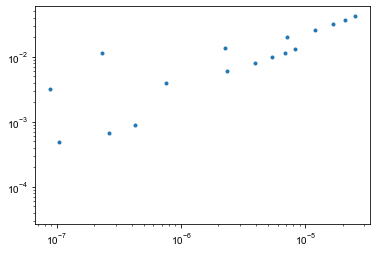

In [22]:
test = []
measure = []
for f in data.keys():
    for amp in data[f].keys():
        output = data[f][amp]['output']
        mppc = np.mean(output[0])
        #test.append(voltint.get_MPPC_voltage('blue', f, amp/100))
        test.append(voltint.get_intensity_MPPC('blue', f, mppc ))
        measure.append(mppc)
#plt.loglog(test, '.')
plt.loglog(test, measure, '.')

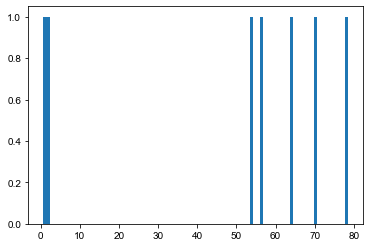

In [20]:
for P in list(ek_values.keys())[::-1]: 
    ek = np.array(ek_values[P])
    M = np.array(M_values[P])
    indices = (M/ek)<1e2
    plt.hist(M[indices]/ek[indices], bins = 100)
    #plt.hist(ek[indices], bins = 100)

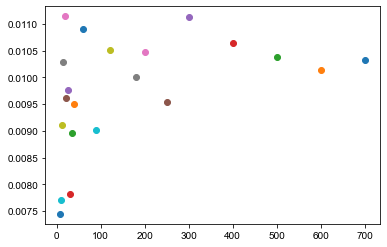

In [81]:
for P in list(ek_values.keys())[::-1]: 
    a3 = np.array(A3[P])
    ek = np.array(ek_values[P])
    M = np.array(M_values[P])
    indices = (M/ek)<1e2
    plt.scatter(P, np.std(M[indices]/ek[indices]))
    #plt.scatter(P, np.sqrt(P)/2000, color = 'b')
    #plt.scatter(P, np.std(a3))

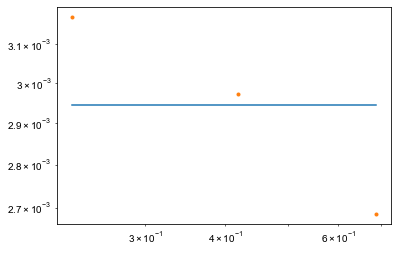

In [38]:
FD_mppc = []
I_mppc = []
i = 0
x0 = [0.001, 0.0005/200]
for f in data.keys():
    for amp in data[f].keys():
        if i > 0:
            data_key = data[f][amp]
            video = data_key["video"]
            output = data_key["output"]
            intensity = output[0, :1000000].mean()# - output[0, 1000000:].mean()
            fluorescence1 = output[1, 150000:300000].mean() - output[1, 1050000:].mean()
            fluorescence2 = output[1, 700000:9000000].mean() - output[1, 1050000:].mean()
            fluorescence = output[1, :1000000].mean()
            #plt.plot(intensity, fluorescence2/intensity, '.')
            #intensity = voltint.get_intensity_MPPC('blue', f, np.mean(output[0,:1000000]))*1e6
            #plt.loglog(intensity, fluorescence2/intensity, '.', color = "r")# col[f])
            i += 1
            I_mppc.append(intensity)
            FD_mppc.append(fluorescence)
        
        else: 
            i+= 1

I_mppc = np.array(I_mppc)
FD_mppc = np.array(FD_mppc)

indices = (FD_mppc < 2.8)*(FD_mppc>5e-4)*(I_mppc>5e-4)*(I_mppc<2.8)

I_mppc = np.array(I_mppc)[indices]
FD_mppc = np.array(FD_mppc)[indices]
parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e5,1e5),
                                        args = (I_mppc, FD_mppc/I_mppc, platt))
(M, ek) = parameters_estimated.x
plt.loglog(I_mppc, platt((M,ek), I_mppc))
plt.loglog(I_mppc, FD_mppc/I_mppc, '.')


In [39]:
I_mppc

array([0.23036947, 0.41890978, 0.68758768])

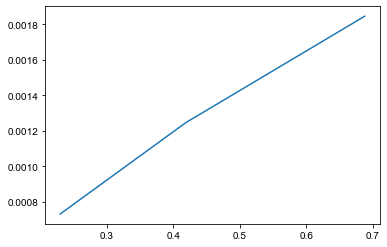

In [40]:
#plt.plot(I, FD)
plt.plot(I_mppc, FD_mppc)

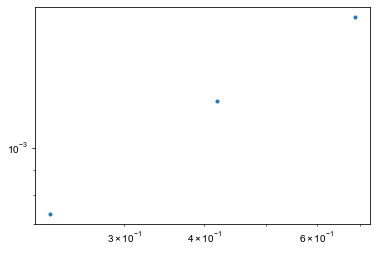

In [41]:
plt.loglog(I_mppc, FD_mppc, ".")


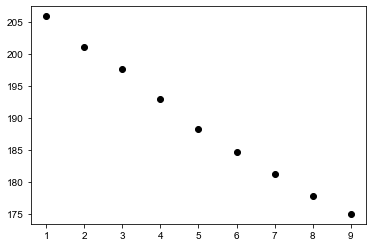

In [42]:
ek_values =[]
x0 = [2, 0.2]

for algae in list(items_dict.keys())[100:101]:
    i = 0
    I = {}
    FD = {}
    for k in range(1,10):
        I[k] = []
        FD[k] = []
        for f in [1,0]:#data.keys():
            for amp in data[f].keys():
                if i > 3:
                    x_coords =  items_dict[algae]['x_coords']
                    y_coords =  items_dict[algae]['y_coords']
                    video = data[f][amp]['video']
                    output = data[f][amp]['output']
                    algae_fluo = np.mean(video[k, x_coords, y_coords])
                    I[k].append(np.mean(output[0]))
                    FD[k].append(algae_fluo)
                    i += 1

                else:
                    i+=1
        #plt.plot(I[k], np.array(FD[k])/np.array(I[k]), label = str(k))#
        plt.scatter(k, FD[k][-1]/I[k][-1], color = 'k')
        #plt.scatter(k, FD[k][-9]/I[k][-9], color = 'b', label = 9)

#plt.legend()

In [43]:
list(items_dict.keys())[10]

'10'